In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from ufs2arco import Layers2Pressure

In [2]:
lp = Layers2Pressure()

In [3]:
import graphufs
plt.style.use("graphufs.plotstyle")

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [4]:
import functools

In [5]:
def swap_dims(open_dataset):

    @functools.wraps(open_dataset)
    def wrapper(*args, **kwargs):
        xds = open_dataset(*args, **kwargs)
        if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
            xds = xds.rename({"prediction_timedelta": "lead_time"})
        
        xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
        xds = xds.swap_dims({"lead_time": "fhr"})
        return xds
    return wrapper

In [6]:
@swap_dims
def open_zarr(*args, **kwargs):
    return xr.open_zarr(*args, **kwargs)
@swap_dims
def open_dataset(*args, **kwargs):
    return xr.open_dataset(*args, **kwargs)

## Error in layer thickness: prognostic vs diagnostic

In [16]:
gds = open_dataset("/p1-evaluation/v1/validation/graphufs_vs_replay_240h_deterministic.nc")
dgds = open_dataset("/p1-evaluation/v1/validation/graphufs_vs_replay_240h_diagdelz_deterministic.nc")
drds = open_dataset("/p1-evaluation/v1/validation/replay_vs_replay_240h_diagdelz_deterministic.nc")

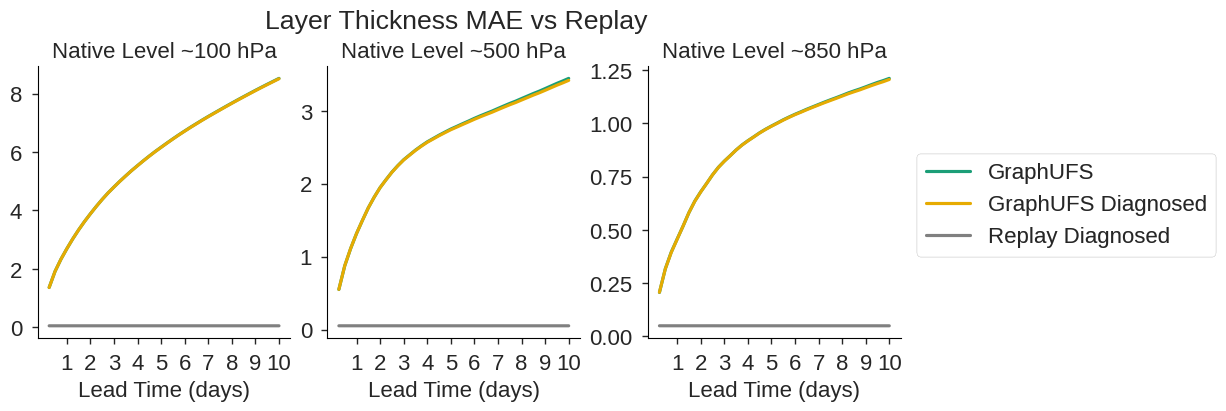

In [27]:
levels = [100, 500, 850]
ncols = len(levels)
fig, axs = plt.subplots(1, ncols, figsize=(3*ncols, 4), constrained_layout=True)

for level, ax in zip(levels, axs):
    sps = ax.get_subplotspec()
    for j, (label, xds) in enumerate(zip(
        ["GraphUFS", "GraphUFS Diagnosed", "Replay Diagnosed"],
        [gds, dgds, drds],
    )):
        plotme = xds["layer_thickness"].sel(level=level, method="nearest")
        plotme = plotme.sel(metric="mae")
        plotme.plot(
            ax=ax,
            color=f"C{j*5}" if "Replay" not in label else "gray",
            label=label if sps.is_first_col() else None,
        )

    xticks = xds.fhr.values[3::4]
    
    ax.set(
        ylabel="",
        xlabel="Lead Time (days)",
        title=f"Native Level ~{level} hPa",
        xticks=xticks,
        xticklabels=[x // 24 for x in xticks],
    )

    fig.suptitle(f"Layer Thickness MAE vs Replay")
    fig.legend(loc="center left", bbox_to_anchor=(1, .5))

fig.savefig(f"figures/diagnosed_vs_predicted_delz.jpeg", bbox_inches="tight", dpi=300)

## Compute a separate derived delz dataset

In [7]:
#import dask
#dask.config.set(scheduler="threads", n_workers=48)

In [8]:
#gds = xr.open_zarr("/p1-evaluation/v1/validation/graphufs.240h.zarr")
#gds = gds.isel(time=slice(None, None, 15))
#rds = xr.open_zarr("/p1-evaluation/v1/validation/replay.240h.zarr")
#rds = rds.isel(time=slice(None, None, 15))
#print(gds)

<xarray.Dataset> Size: 557GB
Dimensions:     (time: 569, lead_time: 40, level: 13, lat: 192, lon: 384)
Coordinates:
  * lat         (lat) float64 2kB 89.82 88.89 87.95 ... -87.25 -88.18 -89.12
  * lead_time   (lead_time) timedelta64[ns] 320B 0 days 06:00:00 ... 10 days ...
  * level       (level) float32 52B 47.81 97.82 145.7 ... 847.8 921.9 998.8
  * lon         (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * time        (time) datetime64[ns] 5kB 2022-01-01T03:00:00 ... 2023-10-02T...
Data variables:
    delz        (time, lead_time, level, lat, lon) float32 87GB dask.array<chunksize=(1, 40, 13, 192, 384), meta=np.ndarray>
    dzdt        (time, lead_time, level, lat, lon) float32 87GB dask.array<chunksize=(1, 40, 13, 192, 384), meta=np.ndarray>
    prateb_ave  (time, lead_time, lat, lon) float32 7GB dask.array<chunksize=(1, 40, 192, 384), meta=np.ndarray>
    pressfc     (time, lead_time, lat, lon) float32 7GB dask.array<chunksize=(1, 40, 192, 384), meta=np.ndarray

In [8]:
#gds = gds.drop_vars("delz")
#gds["delz"] = lp.calc_delz(gds["pressfc"], gds["tmp"], gds["spfh"])
#gds = gds.drop_vars(list(k for k in gds.data_vars if k != "delz"))

In [9]:
#gds.to_zarr("/p1-evaluation/v1/validation/graphufs.240h.diagdelz.zarr")

In [11]:
#rds = rds.drop_vars("delz")
#rds["delz"] = lp.calc_delz(rds["pressfc"], rds["tmp"], rds["spfh"])
#rds = rds.drop_vars(list(k for k in rds.data_vars if k != "delz"))

In [12]:
#rds.to_zarr("/p1-evaluation/v1/validation/replay.240h.diagdelz.zarr")

## Scratch delz comparison

In [ ]:
gds = xr.open_zarr("/p1-evaluation/v1/validation/graphufs.240h.zarr")
gds = gds.isel(time=slice(None, None, 15))
rds = xr.open_zarr("/p1-evaluation/v1/validation/replay.240h.zarr")
rds = rds.isel(time=slice(None, None, 15))
print(gds)

In [122]:
errors = open_dataset("/p1-evaluation/v1/validation/graphufs_vs_replay_240h_deterministic.nc")
spatial = open_dataset("/p1-evaluation/v1/validation/graphufs_vs_replay_240h_deterministic_spatial.nc")
spatial = spatial.rename({"latitude": "lat", "longitude": "lon"})

In [20]:
gds["delz_derived"] = lp.calc_delz(gds["pressfc"], gds["tmp"], gds["spfh"])

In [21]:
diff = gds.delz - gds.delz_derived

In [22]:
reldiff = np.abs(diff) / np.abs(rds.delz)

In [23]:
avg_reldiff = reldiff.mean(["lat", "lon", "time"])

In [24]:
%%time
avg_reldiff = avg_reldiff.compute()

CPU times: user 2min 49s, sys: 7min 31s, total: 10min 21s
Wall time: 1min 5s


In [25]:
%%time
max_reldiff = reldiff.max(["lat", "lon", "time"]).compute()

CPU times: user 3min 30s, sys: 12min, total: 15min 30s
Wall time: 54.8 s


In [33]:
errors["layer_thickness"].sel(metric="mae")

<xarray.DataArray 'layer_thickness' (fhr: 40, level: 6)> Size: 2kB
[240 values with dtype=float64]
Coordinates:
    lead_time  (fhr) timedelta64[ns] 320B 0 days 06:00:00 ... 10 days 00:00:00
  * level      (level) float32 24B 998.8 847.8 505.7 243.9 97.82 47.81
    metric     <U3 12B 'mae'
  * fhr        (fhr) int64 320B 6 12 18 24 30 36 42 ... 210 216 222 228 234 240

In [34]:
relerr = np.abs(diff).sel(level=errors.level) / errors["layer_thickness"].sel(metric="mae")

In [38]:
%%time
avg_relerr = relerr.mean(["lat", "lon", "time"]).compute()
max_relerr = relerr.max(["lat", "lon", "time"]).compute()

CPU times: user 6min 45s, sys: 23min 2s, total: 29min 47s
Wall time: 1min 45s


In [26]:
%%time
avg_absdiff = np.abs(diff).mean(["lat", "lon", "time"]).compute()
max_absdiff = np.abs(diff).max(["lat", "lon", "time"]).compute()

CPU times: user 6min 41s, sys: 22min 9s, total: 28min 50s
Wall time: 1min 41s


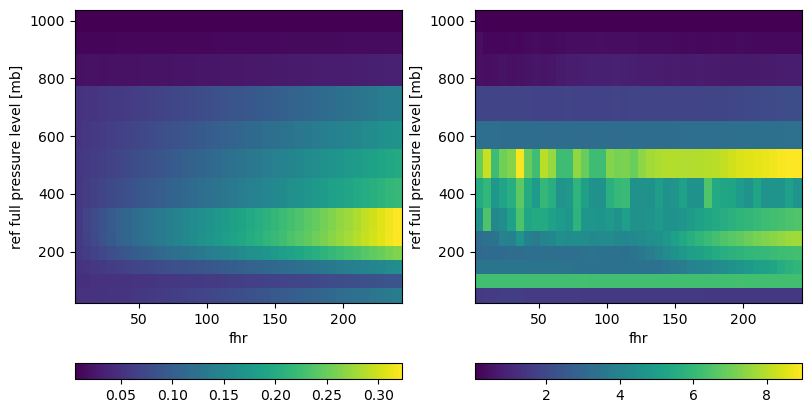

In [27]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
avg_absdiff.plot(x="fhr", ax=axs[0], cbar_kwargs={"orientation":"horizontal"})
max_absdiff.plot(x="fhr", ax=axs[1], cbar_kwargs={"orientation":"horizontal"})

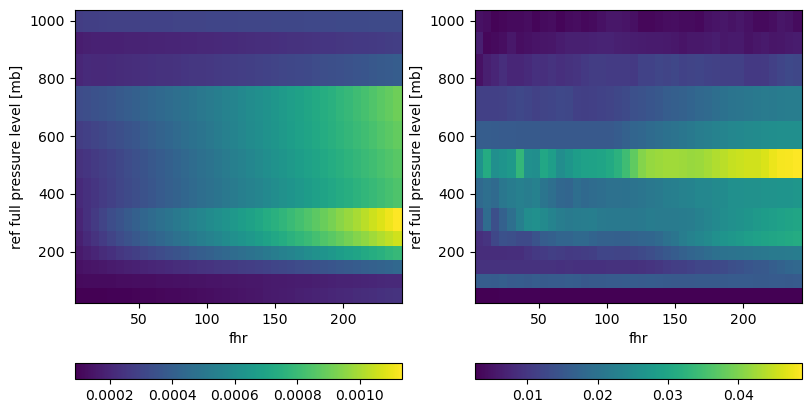

In [28]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
avg_reldiff.plot(x="fhr", ax=axs[0], cbar_kwargs={"orientation":"horizontal"})
max_reldiff.plot(x="fhr", ax=axs[1], cbar_kwargs={"orientation":"horizontal"})

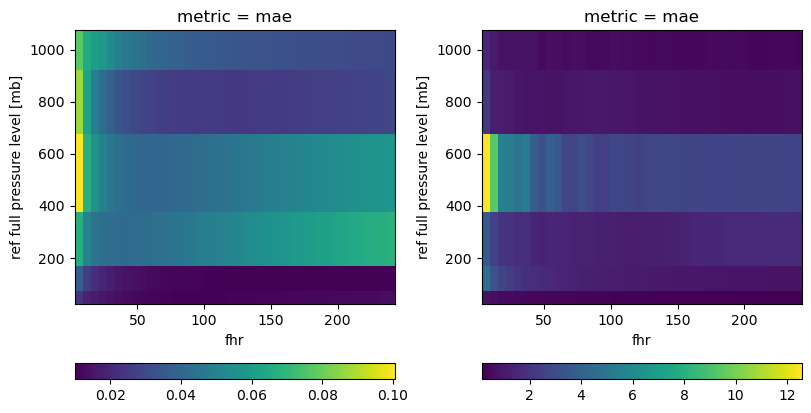

In [39]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
avg_relerr.plot(x="fhr", ax=axs[0], cbar_kwargs={"orientation":"horizontal"})
max_relerr.plot(x="fhr", ax=axs[1], cbar_kwargs={"orientation":"horizontal"})

### Derived 2m Temperature

In [95]:
dz_right = np.abs(gds.delz_derived.isel(level=-1))
dz_left = np.abs(gds.delz_derived.isel(level=-2))

In [96]:
z_b = dz_right / 2
z_bm1 = dz_right + dz_left/2

In [97]:
t_b = gds.tmp.isel(level=-1)
t_bm1 = gds.tmp.isel(level=-2)

In [98]:
t2m_d = (2 - z_b)/(z_bm1 - z_b) * (t_bm1 - t_b) + t_b

In [107]:
diff = (t2m_d - rds.tmp2m)
reldiff = ( np.abs(diff) / rds.tmp2m ).compute()

In [123]:
relerror = (np.abs(diff) / spatial["2m_temperature"].sel(metric="mae")).compute()

In [136]:
extrap = t2m_d - gds.tmp2m
reldiff_extrap = ( np.abs(extrap) / rds.tmp2m ).compute()
relerror_extrap = (np.abs(extrap) / spatial["2m_temperature"].sel(metric="mae")).compute()

[Text(0.5, 1.0, 't2m max_(IC, fhr) {\n|DerivedGraphUFS - Replay| /  (Replay)}')]

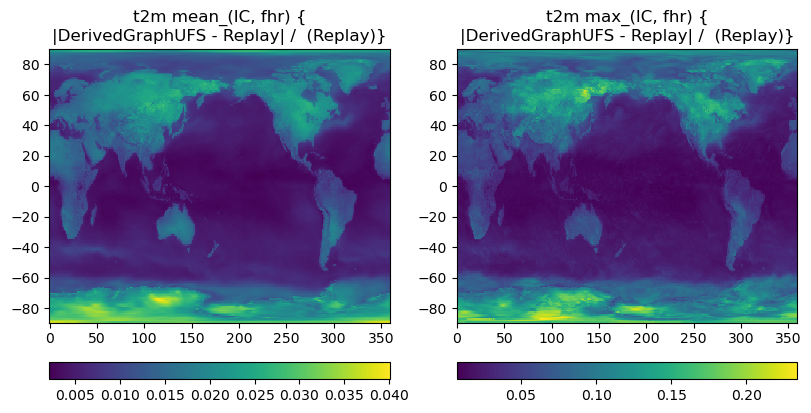

In [138]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
kw = {"cbar_kwargs": {"orientation":"horizontal"}}
reldiff.mean(["time", "fhr"]).plot(ax=axs[0], **kw)
reldiff.max(["time", "fhr"]).plot(ax=axs[1], **kw)
[ax.set(xlabel="", ylabel="") for ax in axs];
axs[0].set(title="t2m mean_(IC, fhr) {\n|DerivedGraphUFS - Replay| /  (Replay)}")
axs[1].set(title="t2m max_(IC, fhr) {\n|DerivedGraphUFS - Replay| /  (Replay)}")

[Text(0.5, 1.0, 't2m max_(IC, fhr) {\n|DerivedGraphUFS - Replay| / \n meanIC|GraphUFS - Replay|}')]

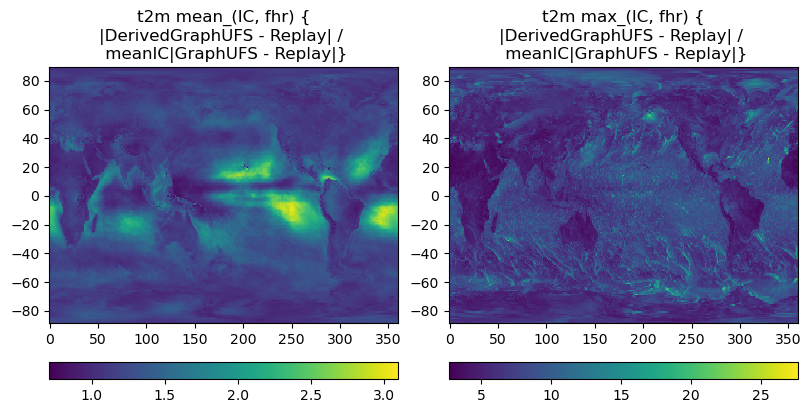

In [139]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
relerror.mean(["time", "fhr"]).plot(ax=axs[0], **kw)
relerror.max(["time", "fhr"]).plot(ax=axs[1], **kw)
[ax.set(xlabel="", ylabel="") for ax in axs];

axs[0].set(title="t2m mean_(IC, fhr) {\n|DerivedGraphUFS - Replay| / \n meanIC|GraphUFS - Replay|}")
axs[1].set(title="t2m max_(IC, fhr) {\n|DerivedGraphUFS - Replay| / \n meanIC|GraphUFS - Replay|}")

[Text(0.5, 1.0, 't2m max_(IC, fhr) {\n|DerivedGraphUFS - GraphUFS| /  (Replay)}')]

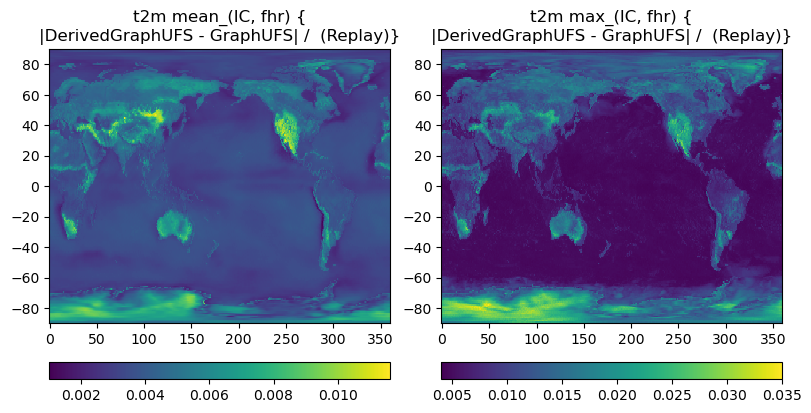

In [140]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
kw = {"cbar_kwargs": {"orientation":"horizontal"}}
reldiff_extrap.mean(["time", "fhr"]).plot(ax=axs[0], **kw)
reldiff_extrap.max(["time", "fhr"]).plot(ax=axs[1], **kw)
[ax.set(xlabel="", ylabel="") for ax in axs];
axs[0].set(title="t2m mean_(IC, fhr) {\n|DerivedGraphUFS - GraphUFS| /  (Replay)}")
axs[1].set(title="t2m max_(IC, fhr) {\n|DerivedGraphUFS - GraphUFS| /  (Replay)}")

[Text(0.5, 1.0, 't2m max_(IC, fhr) {\n|DerivedGraphUFS - GraphUFS| / \n meanIC|GraphUFS - Replay|}')]

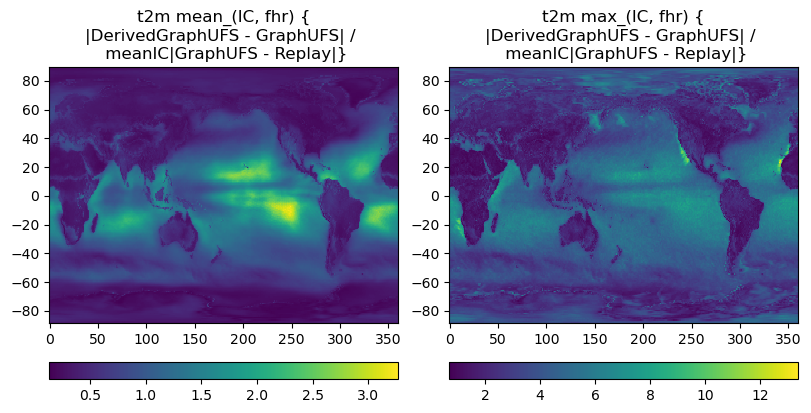

In [141]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
kw = {"cbar_kwargs": {"orientation":"horizontal"}}
relerror_extrap.mean(["time", "fhr"]).plot(ax=axs[0], **kw)
relerror_extrap.max(["time", "fhr"]).plot(ax=axs[1], **kw)
[ax.set(xlabel="", ylabel="") for ax in axs];
axs[0].set(title="t2m mean_(IC, fhr) {\n|DerivedGraphUFS - GraphUFS| / \n meanIC|GraphUFS - Replay|}")
axs[1].set(title="t2m max_(IC, fhr) {\n|DerivedGraphUFS - GraphUFS| / \n meanIC|GraphUFS - Replay|}")

[Text(0.5, 1.0, 't2m |DerivedGraphUFS - Replay| /  meanIC|GraphUFS - Replay|')]

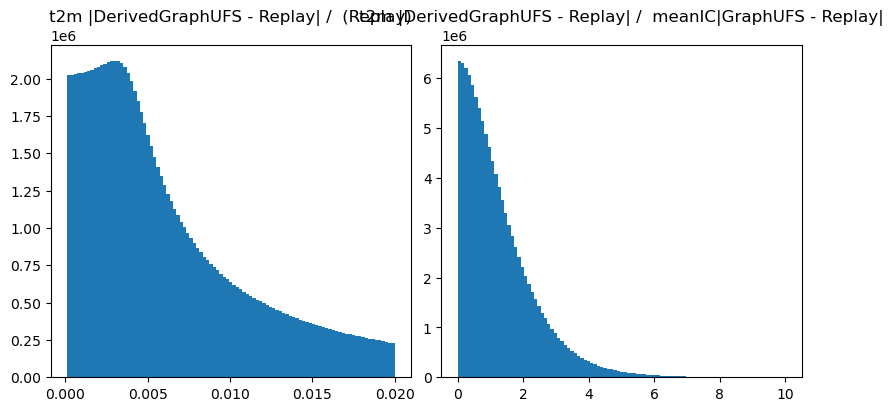

In [143]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
reldiff.plot(bins=np.linspace(0.0001, 0.02, 100), ax=axs[0])
relerror.plot(bins=np.linspace(0.0001, 10., 100), ax=axs[1]);
#axs[0].set(title="2m Temperature |Extrapolated in Replay - Actual| / |Actual|")

axs[0].set(title="t2m |DerivedGraphUFS - Replay| /  (Replay)")
axs[1].set(title="t2m |DerivedGraphUFS - Replay| /  meanIC|GraphUFS - Replay|")
#axs[1].set(title="2m Temperature |Extrapolated in Replay - Actual| / MAE(GraphUFS Prediction)")

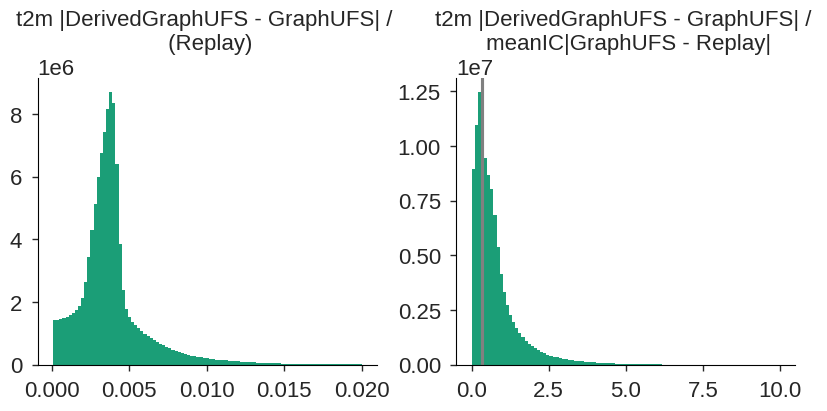

In [150]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
reldiff_extrap.plot(bins=np.linspace(0.0001, 0.02, 100), ax=axs[0])
relerror_extrap.plot(bins=np.linspace(0.0001, 10., 100), ax=axs[1]);
#axs[0].set(title="2m Temperature |Extrapolated in Replay - Actual| / |Actual|")

axs[0].set(title="t2m |DerivedGraphUFS - GraphUFS| / \n (Replay)")
axs[1].set(title="t2m |DerivedGraphUFS - GraphUFS| / \n meanIC|GraphUFS - Replay|")
axs[1].axvline(x=.35, color="gray")
#axs[1].set(title="2m Temperature |Extrapolated in Replay - Actual| / MAE(GraphUFS Prediction)")

Error in the extrapolation is <1% when considering value relative to predicted t2m, but is on average 1/2 the size of the prediction error in GraphUFS.

The situation does not really change whether delz is the predicted or diagnosed version.